In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

In [31]:
motherdir2="C:/Users/infec/Desktop/수자원공사 공모전/사진파일/"
totaldf=pd.read_csv("C:/Users/infec/Desktop/수자원공사 공모전/사진파일/Totaldf.csv", encoding="cp949")

In [68]:
JA=totaldf[["Date", "주암댐"]]
JA.set_index(["Date"], inplace=True)
JA

,주암댐
Date,
2019-06-21,13.74
2019-06-22,12.84
2019-06-23,13.84
2019-06-24,13.59
2019-06-25,12.57
...,...
2021-09-04,18.35
2021-09-05,17.84
2021-09-06,17.88


In [16]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error ,mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [70]:
def moving_average(series, n):
    return np.average(series[-n:])


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rolling_mean=series.rolling(window=window).mean()
    #rolling은 pandas에 있는 기능으로 주어진 날짜로부터 window 일만큼 이전 데이터들에 대한 연산을 할 수 있게 해줌
    plt.figure(figsize=(15, 5))
    plt.title("Moving average \n window size= {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    if plot_intervals:
        mae=mean_absolute_error(series[window:], rolling_mean[window:])
        #실제랑 차이 알아보기
        deviation=np.std(series[window:]-rolling_mean[window:])
        lower_bond=rolling_mean-(mae+scale*deviation)
        upper_bond=rolling_mean+(mae+scale*deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond/ Lower bond")
        plt.plot(lower_bond, "r--")
        if plot_anomalies:
            #outlier 찾아내는 부분
            anomalies=pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series>upper_bond]=series[series>upper_bond]
            anomalies[series>upper_bond]=series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(series.index, rotation=45)
    plt.locator_params(axis="x", nbins=len(series.index)/5)

In [69]:
JA

,주암댐
Date,
2019-06-21,13.74
2019-06-22,12.84
2019-06-23,13.84
2019-06-24,13.59
2019-06-25,12.57
...,...
2021-09-04,18.35
2021-09-05,17.84
2021-09-06,17.88


In [37]:

JA2019=JA["2019-06-21": "2019-09-20"]
JA2021=JA["2021-06-21": "2021-09-20"]

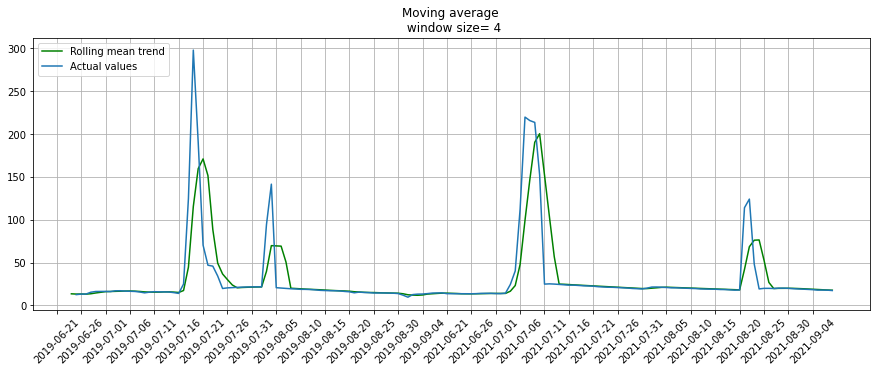

In [71]:
plotMovingAverage(JA, 4)


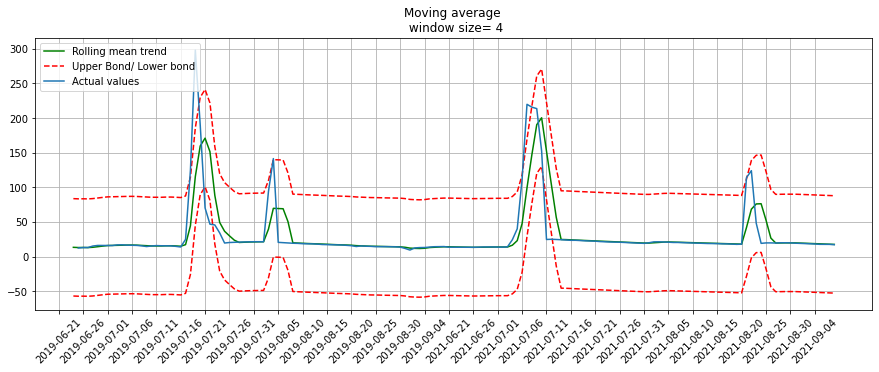

In [72]:
plotMovingAverage(JA, 4, plot_intervals=True)
plt.savefig(motherdir2+"JA2021 moving average", dpi=200)

In [39]:
def weighted_average(series, weights):
    result=0.0
    for n in range(len(weights)):
        result+=series.iloc[-n-1]*weights[n]
    return float(result)

def exponential_smoothing(series, alpha):
    
    #이 그림은 단순지수평활
    #지수평활법에서 alpha의 값을 조정해가면서 추세를 제일 잘 반영해주는 alpha를 찾는 것
    
    
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)
        plt.show()

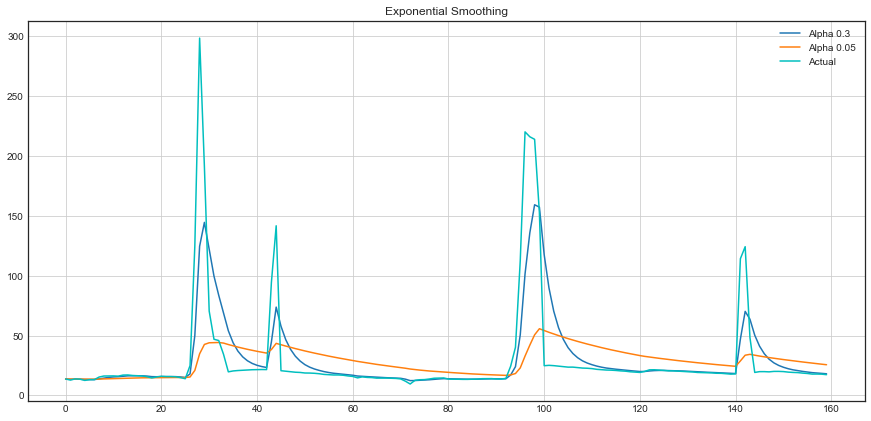

In [73]:
plotExponentialSmoothing(JA["주암댐"], [0.3, 0.05])

In [43]:
def double_exponential_smoothing(series, alpha, beta):
    result=[series[0]]
    for n in range(1, len(series)+1):
        if n==1:
            level, trend=series[0], series[1]-series[0]
        if n>=len(series):
            value=result[-1]
        else:
            value=series[n]
        last_level, level=level, alpha*value+(1-alpha)*(level+trend)
        trend=beta*(level-last_level)+(1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double exponential smoothing")
        plt.grid(True)
        

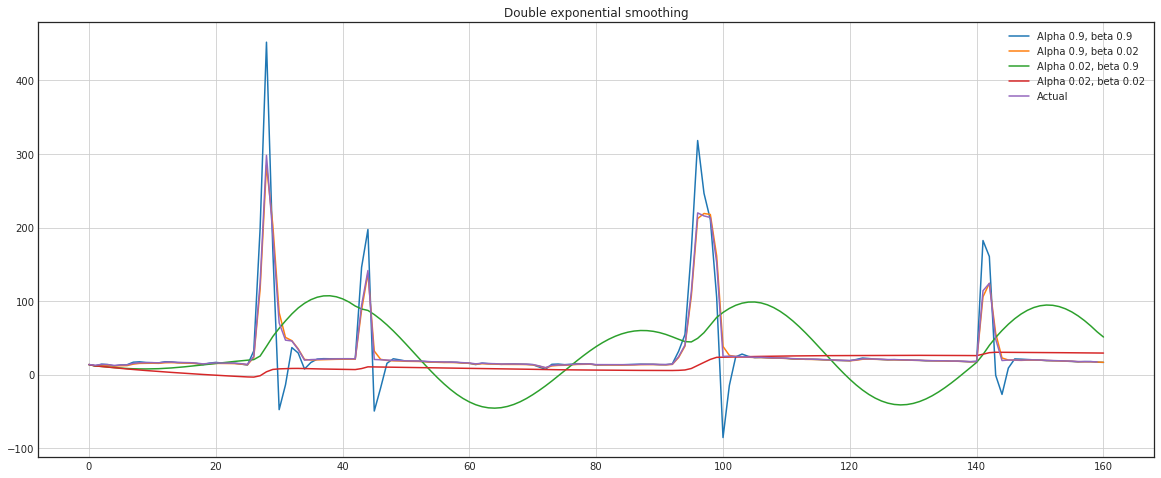

In [58]:
plotDoubleExponentialSmoothing(totaldf["주암댐"], alphas=[0.9, 0.02], betas=[0.9, 0.02])
plt.savefig(motherdir2+"JA 2019 double exponential smoothing")

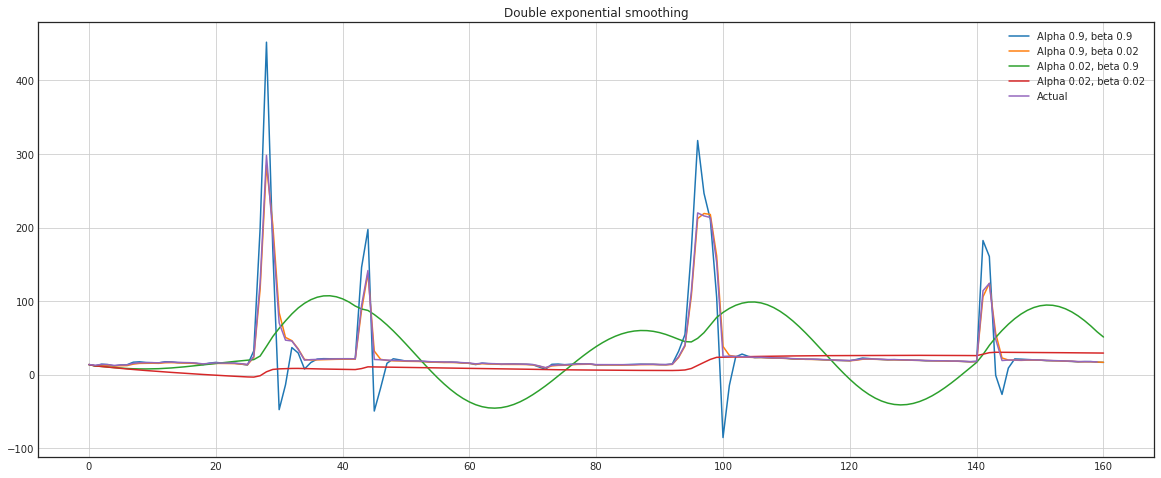

In [60]:
plotDoubleExponentialSmoothing(totaldf["주암댐"], alphas=[0.9, 0.02], betas=[0.9, 0.02])
plt.savefig(motherdir2+"JA 2021 double exponential smoothing")

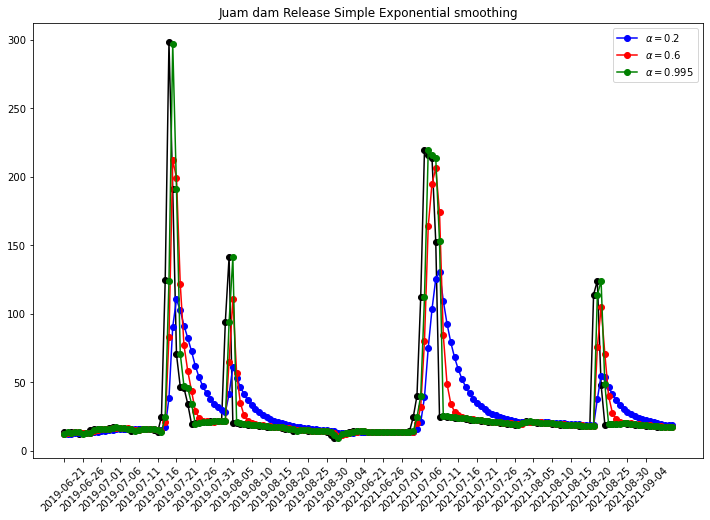

In [82]:
fit1 = SimpleExpSmoothing(JA, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(JA, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(JA, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(JA, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])
plt.xticks(JA.index, rotation=45)
plt.locator_params(axis="x", nbins=len(JA.index)/5)
plt.title("Juam dam Release Simple Exponential smoothing")
plt.savefig(motherdir2+"JA SES", dpi=200)

In [106]:
def timecorr(datax, datay):
    return datax.corr(datay)
timecorr(JA["주암댐"], fit1.fittedvalues)

0.4019019048629635

In [108]:
timecorr(JA["주암댐"], fit2.fittedvalues)

0.6538353129068293

In [107]:
timecorr(JA["주암댐"], fit3.fittedvalues)

0.7543290181359522

160    17.553951
161    17.553951
162    17.553951
163    17.553951
164    17.553951
165    17.553951
166    17.553951
167    17.553951
168    17.553951
169    17.553951
170    17.553951
171    17.553951
172    17.553951
dtype: float64